Importing Libraries

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, optimizers, losses
from tqdm import tqdm
from math import isclose
from DIY_Library import *

We generate trajectories with energies between Emin and Emax (bounded region 0 < E < 1/6)  

We save them as csv files (Using pandas Dataframes for handling data)

They are of the size :  
X: (400000, 4)  
dX: (400000, 4)  
Energies: (400000,)

In [ ]:
Emin, Emax = 0.001, 1/6 - 1e-6
n_energies = 20
orbits_per_energy = 20

dt = 0.1                      
orbit_time = 100            
steps_per_traj = int(orbit_time / dt)   

X, dX, energies = generate_exact_dataset(Emin=Emin, Emax=Emax, n_energies=n_energies, orbit_time=orbit_time
                                        orbits_per_energy=orbits_per_energy, dt=dt)

df_X = pd.DataFrame(X, columns=["qx", "qy", "px", "py"])
df_dX = pd.DataFrame(dX, columns=["dqx", "dqy", "dpx", "dpy"])
df_E = pd.DataFrame(energies, columns=["Energy"])

df_X.to_csv("X.csv", index=False)
df_dX.to_csv("dX.csv", index=False)
df_E.to_csv("energies.csv", index=False)

print("X:", X.shape)
print("dX:", dX.shape)
print("Energies:", energies.shape)

Energy levels: 100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


X: (400000, 4)
dX: (400000, 4)
Energies: (400000,)


We define the Neural network with parameters as given in the paper  
ANN and HNN   
The summary displayed below shows the architecture used.


In [3]:
ANN_model = ANN()
HNN_model = HNN()
print(ANN_model.summary())
print(HNN_model.summary())

Model: "ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,004 (164.08 KB)

 Trainable params: 42,004 (164.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "HNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,401 (161.72 KB)

 Trainable params: 41,401 (161.72 KB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
df_X = pd.read_csv("X.csv")
df_dX = pd.read_csv("dX.csv")
df_E = pd.read_csv("energies.csv")

X = df_X.to_numpy()
dX = df_dX.to_numpy()
energies = df_E.to_numpy().flatten()  


print("X:", X.shape)
print("dX:", dX.shape)
print("Energies:", energies.shape)

X: (400000, 4)
dX: (400000, 4)
Energies: (400000,)


We train both the models identically using same batch size, optimizer, learning rate and activation functions

In [25]:
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices((X, dX)).shuffle(10000, seed=42).batch(batch_size)

epochs = 50
lr = 1e-4
optimizer_ANN = optimizers.Adam(learning_rate=lr)
optimizer_HNN = optimizers.Adam(learning_rate=lr)

Loss_ANN_Train = []
Loss_HNN_Train = []

MSE = losses.MeanSquaredError()

@tf.function
def train_step_nn(x_batch, dx_batch):
    with tf.GradientTape() as tape:
        pred = ANN_model(x_batch, training=True)
        loss = MSE(dx_batch, pred)
    grads = tape.gradient(loss, ANN_model.trainable_variables)
    optimizer_ANN.apply_gradients(zip(grads, ANN_model.trainable_variables))
    return loss


@tf.function
def train_step_hnn(x_batch, dx_batch):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_batch)
        H_pred = HNN_model(x_batch, training=True)  
        grads = tape.gradient(H_pred, x_batch)  
        dH_dqx = grads[:,0:1]
        dH_dqy = grads[:,1:2]
        dH_dpx = grads[:,2:3]
        dH_dpy = grads[:,3:4]
        dq_pred = tf.concat([dH_dpx, dH_dpy], axis=1)
        dp_pred = -tf.concat([dH_dqx, dH_dqy], axis=1)
        pred = tf.concat([dq_pred, dp_pred], axis=1)
        loss = tf.reduce_mean(tf.square(dx_batch - pred))
    grads_vars = tape.gradient(loss, HNN_model.trainable_variables)
    optimizer_HNN.apply_gradients(zip(grads_vars, HNN_model.trainable_variables))
    del tape
    return loss

for epoch in range(1, epochs+1):
    pbar = tqdm(dataset, desc=f'Epoch {epoch}/{epochs}')
    Loss_ANN_Epoch = []
    Loss_HNN_Epoch = []
    for x_batch, dx_batch in pbar:
        ln = train_step_nn(x_batch, dx_batch)
        lh = train_step_hnn(x_batch, dx_batch)
        Loss_ANN_Epoch.append(float(ln))
        Loss_HNN_Epoch.append(float(lh))
        pbar.set_postfix({'lnn': float(np.mean(Loss_ANN_Epoch)), 'lhnn': float(np.mean(Loss_HNN_Epoch))})
    Loss_ANN_Train.append(float(np.mean(Loss_ANN_Epoch)))
    Loss_HNN_Train.append(float(np.mean(Loss_HNN_Epoch)))
    print(f'Epoch {epoch}: NN loss={Loss_ANN_Train[-1]:.4e}, HNN loss={Loss_HNN_Train[-1]:.4e}')

Epoch 1/50:   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\Aryan Shrivastava\.conda\envs\mlenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['dense_11/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epoch 1/50: 100%|██████████| 1563/1563 [00:19<00:00, 82.10it/s, lnn=0.00421, lhnn=0.00556] 


Epoch 1: NN loss=4.2145e-03, HNN loss=5.5574e-03


Epoch 2/50: 100%|██████████| 1563/1563 [00:11<00:00, 141.37it/s, lnn=0.00382, lhnn=4.51e-5]


Epoch 2: NN loss=3.8241e-03, HNN loss=4.5123e-05


Epoch 3/50: 100%|██████████| 1563/1563 [00:11<00:00, 133.73it/s, lnn=0.000706, lhnn=2.95e-5]


Epoch 3: NN loss=7.0633e-04, HNN loss=2.9508e-05


Epoch 4/50: 100%|██████████| 1563/1563 [00:11<00:00, 131.73it/s, lnn=0.000111, lhnn=2.12e-5]


Epoch 4: NN loss=1.1065e-04, HNN loss=2.1203e-05


Epoch 5/50: 100%|██████████| 1563/1563 [00:10<00:00, 143.03it/s, lnn=6.02e-5, lhnn=1.64e-5]


Epoch 5: NN loss=6.0170e-05, HNN loss=1.6374e-05


Epoch 6/50: 100%|██████████| 1563/1563 [00:10<00:00, 148.43it/s, lnn=3.45e-5, lhnn=1.35e-5]


Epoch 6: NN loss=3.4500e-05, HNN loss=1.3545e-05


Epoch 7/50: 100%|██████████| 1563/1563 [00:10<00:00, 142.55it/s, lnn=2.25e-5, lhnn=1.17e-5]


Epoch 7: NN loss=2.2459e-05, HNN loss=1.1669e-05


Epoch 8/50: 100%|██████████| 1563/1563 [00:11<00:00, 140.73it/s, lnn=1.53e-5, lhnn=1.05e-5]


Epoch 8: NN loss=1.5290e-05, HNN loss=1.0470e-05


Epoch 9/50: 100%|██████████| 1563/1563 [00:10<00:00, 145.88it/s, lnn=1.09e-5, lhnn=9.71e-6]


Epoch 9: NN loss=1.0888e-05, HNN loss=9.7050e-06


Epoch 10/50: 100%|██████████| 1563/1563 [00:10<00:00, 146.82it/s, lnn=7.83e-6, lhnn=8.83e-6]


Epoch 10: NN loss=7.8259e-06, HNN loss=8.8308e-06


Epoch 11/50: 100%|██████████| 1563/1563 [00:11<00:00, 140.80it/s, lnn=5.88e-6, lhnn=8.2e-6] 


Epoch 11: NN loss=5.8817e-06, HNN loss=8.1959e-06


Epoch 12/50: 100%|██████████| 1563/1563 [00:10<00:00, 149.65it/s, lnn=4.56e-6, lhnn=7.66e-6]


Epoch 12: NN loss=4.5634e-06, HNN loss=7.6569e-06


Epoch 13/50: 100%|██████████| 1563/1563 [00:10<00:00, 147.66it/s, lnn=3.77e-6, lhnn=7.31e-6]


Epoch 13: NN loss=3.7713e-06, HNN loss=7.3086e-06


Epoch 14/50: 100%|██████████| 1563/1563 [00:10<00:00, 142.48it/s, lnn=3.39e-6, lhnn=6.96e-6]


Epoch 14: NN loss=3.3891e-06, HNN loss=6.9644e-06


Epoch 15/50: 100%|██████████| 1563/1563 [00:10<00:00, 149.95it/s, lnn=3.03e-6, lhnn=6.6e-6] 


Epoch 15: NN loss=3.0291e-06, HNN loss=6.5961e-06


Epoch 16/50: 100%|██████████| 1563/1563 [00:10<00:00, 143.33it/s, lnn=2.74e-6, lhnn=6.42e-6]


Epoch 16: NN loss=2.7437e-06, HNN loss=6.4167e-06


Epoch 17/50: 100%|██████████| 1563/1563 [00:10<00:00, 149.45it/s, lnn=2.49e-6, lhnn=6.09e-6]


Epoch 17: NN loss=2.4894e-06, HNN loss=6.0884e-06


Epoch 18/50: 100%|██████████| 1563/1563 [00:10<00:00, 147.28it/s, lnn=2.39e-6, lhnn=5.82e-6]


Epoch 18: NN loss=2.3905e-06, HNN loss=5.8162e-06


Epoch 19/50: 100%|██████████| 1563/1563 [00:12<00:00, 126.74it/s, lnn=2.25e-6, lhnn=5.63e-6]


Epoch 19: NN loss=2.2475e-06, HNN loss=5.6295e-06


Epoch 20/50: 100%|██████████| 1563/1563 [00:12<00:00, 120.52it/s, lnn=2.11e-6, lhnn=5.42e-6]


Epoch 20: NN loss=2.1142e-06, HNN loss=5.4157e-06


Epoch 21/50: 100%|██████████| 1563/1563 [00:12<00:00, 125.58it/s, lnn=2.05e-6, lhnn=5.33e-6]


Epoch 21: NN loss=2.0549e-06, HNN loss=5.3277e-06


Epoch 22/50: 100%|██████████| 1563/1563 [00:53<00:00, 29.47it/s, lnn=1.96e-6, lhnn=5.1e-6] 


Epoch 22: NN loss=1.9564e-06, HNN loss=5.0999e-06


Epoch 23/50: 100%|██████████| 1563/1563 [00:32<00:00, 47.61it/s, lnn=1.87e-6, lhnn=4.95e-6] 


Epoch 23: NN loss=1.8722e-06, HNN loss=4.9540e-06


Epoch 24/50: 100%|██████████| 1563/1563 [00:10<00:00, 143.68it/s, lnn=1.78e-6, lhnn=4.82e-6]


Epoch 24: NN loss=1.7772e-06, HNN loss=4.8245e-06


Epoch 25/50: 100%|██████████| 1563/1563 [00:11<00:00, 138.97it/s, lnn=1.76e-6, lhnn=4.72e-6]


Epoch 25: NN loss=1.7594e-06, HNN loss=4.7165e-06


Epoch 26/50: 100%|██████████| 1563/1563 [00:13<00:00, 118.77it/s, lnn=1.65e-6, lhnn=4.54e-6]


Epoch 26: NN loss=1.6462e-06, HNN loss=4.5359e-06


Epoch 27/50: 100%|██████████| 1563/1563 [00:11<00:00, 137.98it/s, lnn=1.67e-6, lhnn=4.49e-6]


Epoch 27: NN loss=1.6743e-06, HNN loss=4.4912e-06


Epoch 28/50: 100%|██████████| 1563/1563 [00:14<00:00, 110.98it/s, lnn=1.59e-6, lhnn=4.35e-6]


Epoch 28: NN loss=1.5912e-06, HNN loss=4.3513e-06


Epoch 29/50: 100%|██████████| 1563/1563 [00:12<00:00, 127.13it/s, lnn=1.58e-6, lhnn=4.19e-6]


Epoch 29: NN loss=1.5780e-06, HNN loss=4.1873e-06


Epoch 30/50: 100%|██████████| 1563/1563 [00:11<00:00, 134.79it/s, lnn=1.5e-6, lhnn=4.18e-6] 


Epoch 30: NN loss=1.5046e-06, HNN loss=4.1782e-06


Epoch 31/50: 100%|██████████| 1563/1563 [00:10<00:00, 149.66it/s, lnn=1.46e-6, lhnn=3.96e-6]


Epoch 31: NN loss=1.4568e-06, HNN loss=3.9632e-06


Epoch 32/50: 100%|██████████| 1563/1563 [00:11<00:00, 134.38it/s, lnn=1.42e-6, lhnn=3.9e-6] 


Epoch 32: NN loss=1.4184e-06, HNN loss=3.8953e-06


Epoch 33/50: 100%|██████████| 1563/1563 [00:10<00:00, 145.00it/s, lnn=1.43e-6, lhnn=3.86e-6]


Epoch 33: NN loss=1.4253e-06, HNN loss=3.8557e-06


Epoch 34/50: 100%|██████████| 1563/1563 [00:12<00:00, 129.43it/s, lnn=1.39e-6, lhnn=3.77e-6]


Epoch 34: NN loss=1.3906e-06, HNN loss=3.7655e-06


Epoch 35/50: 100%|██████████| 1563/1563 [00:12<00:00, 125.95it/s, lnn=1.29e-6, lhnn=3.6e-6] 


Epoch 35: NN loss=1.2937e-06, HNN loss=3.5988e-06


Epoch 36/50: 100%|██████████| 1563/1563 [00:12<00:00, 124.15it/s, lnn=1.36e-6, lhnn=3.6e-6] 


Epoch 36: NN loss=1.3572e-06, HNN loss=3.6009e-06


Epoch 37/50: 100%|██████████| 1563/1563 [00:12<00:00, 124.84it/s, lnn=1.28e-6, lhnn=3.56e-6]


Epoch 37: NN loss=1.2828e-06, HNN loss=3.5585e-06


Epoch 38/50: 100%|██████████| 1563/1563 [00:12<00:00, 122.70it/s, lnn=1.35e-6, lhnn=3.37e-6]


Epoch 38: NN loss=1.3498e-06, HNN loss=3.3674e-06


Epoch 39/50: 100%|██████████| 1563/1563 [00:11<00:00, 133.89it/s, lnn=1.26e-6, lhnn=3.3e-6] 


Epoch 39: NN loss=1.2558e-06, HNN loss=3.2989e-06


Epoch 40/50: 100%|██████████| 1563/1563 [00:17<00:00, 89.39it/s, lnn=1.24e-6, lhnn=3.23e-6]


Epoch 40: NN loss=1.2430e-06, HNN loss=3.2345e-06


Epoch 41/50: 100%|██████████| 1563/1563 [00:36<00:00, 42.83it/s, lnn=1.26e-6, lhnn=3.22e-6] 


Epoch 41: NN loss=1.2573e-06, HNN loss=3.2165e-06


Epoch 42/50: 100%|██████████| 1563/1563 [00:14<00:00, 104.41it/s, lnn=1.15e-6, lhnn=3.18e-6]


Epoch 42: NN loss=1.1515e-06, HNN loss=3.1807e-06


Epoch 43/50: 100%|██████████| 1563/1563 [00:12<00:00, 122.74it/s, lnn=1.15e-6, lhnn=2.97e-6]


Epoch 43: NN loss=1.1484e-06, HNN loss=2.9742e-06


Epoch 44/50: 100%|██████████| 1563/1563 [00:12<00:00, 121.38it/s, lnn=1.16e-6, lhnn=3e-6]   


Epoch 44: NN loss=1.1569e-06, HNN loss=3.0040e-06


Epoch 45/50: 100%|██████████| 1563/1563 [00:13<00:00, 115.00it/s, lnn=1.12e-6, lhnn=2.85e-6]


Epoch 45: NN loss=1.1248e-06, HNN loss=2.8535e-06


Epoch 46/50: 100%|██████████| 1563/1563 [00:11<00:00, 135.04it/s, lnn=1.08e-6, lhnn=2.81e-6]


Epoch 46: NN loss=1.0770e-06, HNN loss=2.8085e-06


Epoch 47/50: 100%|██████████| 1563/1563 [00:12<00:00, 127.65it/s, lnn=1.09e-6, lhnn=2.76e-6]


Epoch 47: NN loss=1.0923e-06, HNN loss=2.7595e-06


Epoch 48/50: 100%|██████████| 1563/1563 [00:11<00:00, 131.20it/s, lnn=1.11e-6, lhnn=2.7e-6] 


Epoch 48: NN loss=1.1055e-06, HNN loss=2.6995e-06


Epoch 49/50: 100%|██████████| 1563/1563 [00:12<00:00, 125.58it/s, lnn=1.04e-6, lhnn=2.65e-6]


Epoch 49: NN loss=1.0404e-06, HNN loss=2.6505e-06


Epoch 50/50: 100%|██████████| 1563/1563 [00:11<00:00, 138.94it/s, lnn=1.12e-6, lhnn=2.59e-6]


Epoch 50: NN loss=1.1162e-06, HNN loss=2.5901e-06


Saving the models in .keras files

In [26]:
ANN_model.save('ANN_Model.keras')
HNN_model.save('HNN_Model.keras')

Loading the models from the .keras files

In [5]:
ANN_model = tf.keras.models.load_model('ANN_Model.keras')
HNN_model = tf.keras.models.load_model('HNN_Model.keras')

print(ANN_model.summary())
print(HNN_model.summary())

Model: "ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,004 (164.08 KB)

 Trainable params: 42,004 (164.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "HNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,401 (161.72 KB)

 Trainable params: 41,401 (161.72 KB)

 Non-trainable params: 0 (0.00 B)

None


Now we predict the trajectories using ANN and HNN models and compare them with our standard library function RK4 

In [87]:
dt = 0.1
steps = 1800

def ANN_Predict(z):
    z = np.asarray(z).reshape(1,4).astype(np.float32)
    return ANN_model.predict(z, verbose=0)[0]  # dz/dt

def HNN_Predict(z):
    ztf = tf.convert_to_tensor(np.asarray(z).reshape(1,4).astype(np.float32))
    with tf.GradientTape() as tape:
        tape.watch(ztf)
        H = HNN_model(ztf)
    grads = tape.gradient(H, ztf).numpy().reshape(-1)
    dq = grads[2:4]
    dp = -grads[0:2]
    return np.concatenate([dq, dp])

def rk4_step(f, z, dt):
    k1 = f(z)
    k2 = f(z + 0.5*dt*k1)
    k3 = f(z + 0.5*dt*k2)
    k4 = f(z + dt*k3)
    return z + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def rollout_true(z0, dt=0.1, steps=1000):
    T = steps * dt
    t_eval = np.linspace(0, T, steps+1)
    sol = solve_ivp(Hamiltonian_ODE_solve,(0, T), z0, t_eval=t_eval, method="RK45", rtol=1e-9, atol=1e-12)
    return sol.y.T

#I tried different methods for ANN rollout as suggested in the paper
#RK4 took too long so and some other methods diveged
#So I used Euler method as the paper had also used 
def rollout_ann(z0, dt=0.1, steps=1000):
    tr = np.zeros((steps+1,4))
    tr[0] = z0
    z = z0.copy()
    for i in tqdm(range(steps), desc="ANN Euler", ncols=80):
        dz = ANN_Predict(z)
        z = z + dt * dz
        tr[i+1] = z
    return tr

#Have to use RK4 for HNN rollout as suggested in the paper, also its not slow compared to ANN
#HNN rollout with RK4 is much faster than ANN with Euler
def rollout_hnn(z0, dt=0.1, steps=1000):
    tr = np.zeros((steps+1,4))
    tr[0] = z0
    z = z0.copy()
    for i in tqdm(range(steps), desc="HNN RK4", ncols=80):
        z = rk4_step(HNN_Predict, z, dt)
        tr[i+1] = z
    return tr

#Standard library RK4 rollout
def rollout_lib(z0, dt=0.1, steps=1000):
    tr = np.zeros((steps+1,4))
    tr[0] = z0
    z = z0.copy()
    for i in tqdm(range(steps), desc="Library RK4", ncols=80):
        z = rk4_step(lambda zz: np.array(Hamiltonian_ODE_solve(0, zz)), z, dt)
        tr[i+1] = z
    return tr

energies_test = np.linspace(0.001, 1/6 - 1e-6, 5)
test_initials = [sample_initial_condition(E) for E in energies_test]

results = {}
for idx, (E, z0) in enumerate(zip(energies_test, test_initials), start=1):
    print(f"\n=== Energy {idx}/5 | E = {E:.6f} ===")
    traj_true = rollout_true(z0, dt=0.005, steps=steps)
    traj_ann  = rollout_ann(z0, dt=dt, steps=steps)
    traj_hnn  = rollout_hnn(z0, dt=dt, steps=steps)
    traj_lib  = rollout_lib(z0, dt=dt, steps=steps)
    results[E] = {
        "z0": z0,
        "true": traj_true,
        "ann": traj_ann,
        "hnn": traj_hnn,
        "lib": traj_lib,
    }

print("\nAll rollouts completed! 'results' dictionary is ready.")



=== Energy 1/5 | E = 0.001000 ===


Library RK4: 100%|███████████████████████| 1800/1800 [00:00<00:00, 82595.75it/s]



=== Energy 2/5 | E = 0.042416 ===


Library RK4: 100%|███████████████████████| 1800/1800 [00:00<00:00, 74634.69it/s]



=== Energy 3/5 | E = 0.083833 ===


Library RK4: 100%|███████████████████████| 1800/1800 [00:00<00:00, 65999.49it/s]



=== Energy 4/5 | E = 0.125249 ===


Library RK4: 100%|███████████████████████| 1800/1800 [00:00<00:00, 65861.88it/s]



=== Energy 5/5 | E = 0.166666 ===


Library RK4: 100%|███████████████████████| 1800/1800 [00:00<00:00, 78546.65it/s]


All rollouts completed! 'results' dictionary is ready.


Plotting the trajectories   
Divergence was observed for ANN  
So, I will plot till the time step that its stable (observing directly by plotting for different timesteps, I came up with these time cutoff numbers after which the ANN trajectory diverges) 

E=0.001000  plotting first 100 steps (ANN's stable trajectory range)


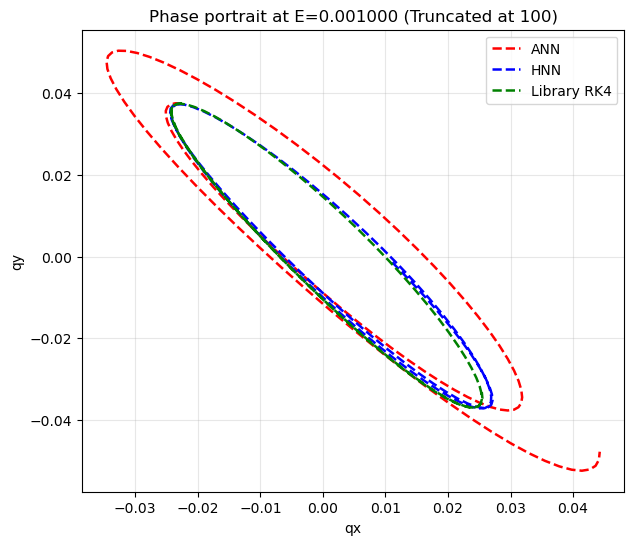

E=0.042416  plotting first 100 steps (ANN's stable trajectory range)


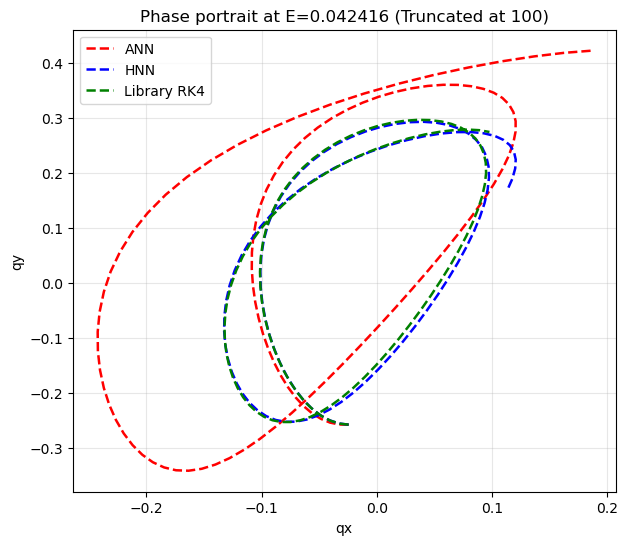

E=0.083833  plotting first 100 steps (ANN's stable trajectory range)


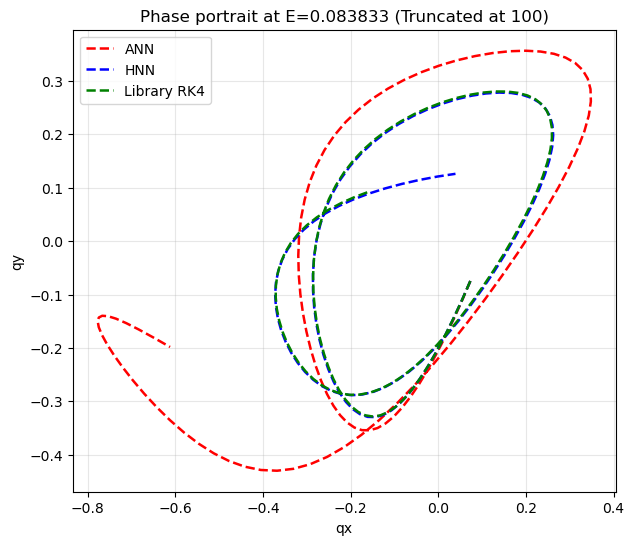

E=0.125249  plotting first 70 steps (ANN's stable trajectory range)


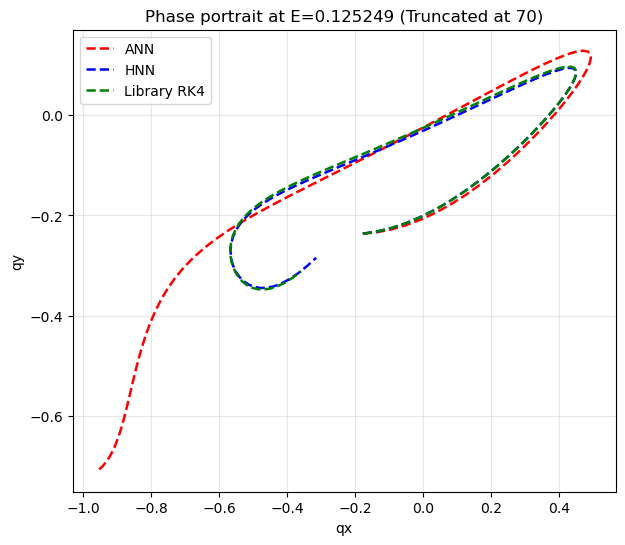

E=0.166666  plotting first 60 steps (ANN's stable trajectory range)


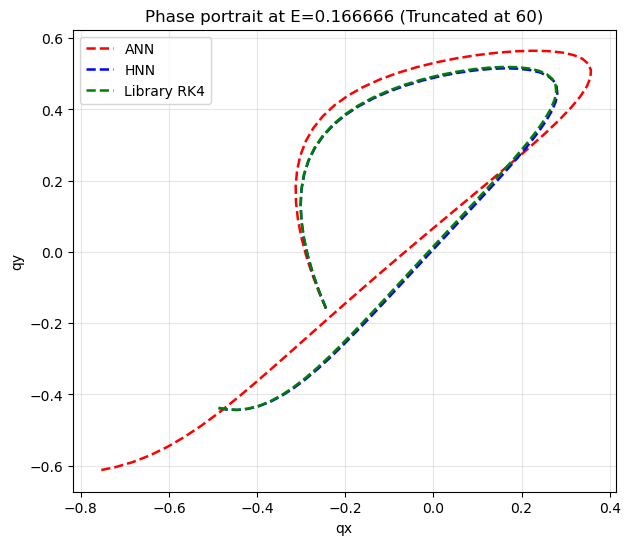

In [134]:
#The ANN Trajectories diverge after some time, so I am plotting only the stable parts
#It shows that HNN is much more stable than ANN
#Since ANN diverges at different times for different energies
#The cutoffs here are the time steps after I observed ANN trajectories diverging for each energy
cutoffs = {
    energies_test[0]: 100,
    energies_test[1]: 100,
    energies_test[2]: 100,
    energies_test[3]: 70,
    energies_test[4]: 60,
}

for E in energies_test:
    R = results[E]
    if E in cutoffs:
        N = cutoffs[E]

    print(f"E={E:.6f}  plotting first {N} steps (ANN's stable trajectory range)")
    plt.figure(figsize=(7,6))
    plt.plot(R["ann"][:N,0], R["ann"][:N,1], 'r--', label=f"ANN")
    plt.plot(R["hnn"][:N,0], R["hnn"][:N,1], 'b--', label=f"HNN")
    plt.plot(R["lib"][:N,0], R["lib"][:N,1], 'g--', label=f"Library RK4")

    plt.xlabel("qx")
    plt.ylabel("qy")
    plt.title(f"Phase portrait at E={E:.6f} (Truncated at {N})")
    plt.legend()
    plt.grid(True)
    plt.show()

E=0.001000  plotting first 100 steps (ANN's stable trajectory range)


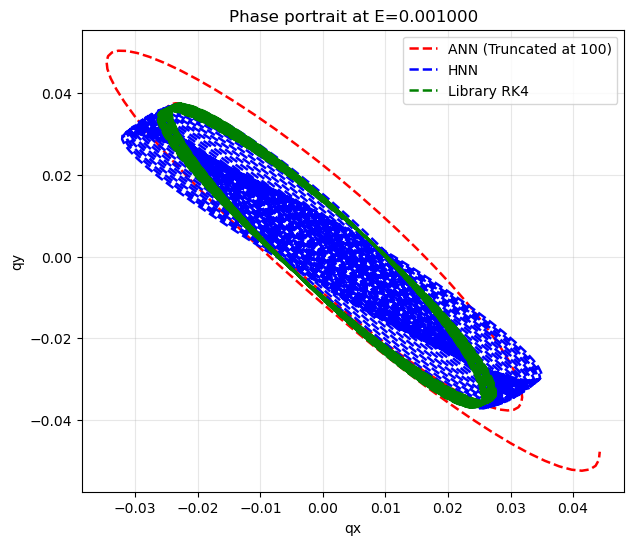

E=0.042416  plotting first 100 steps (ANN's stable trajectory range)


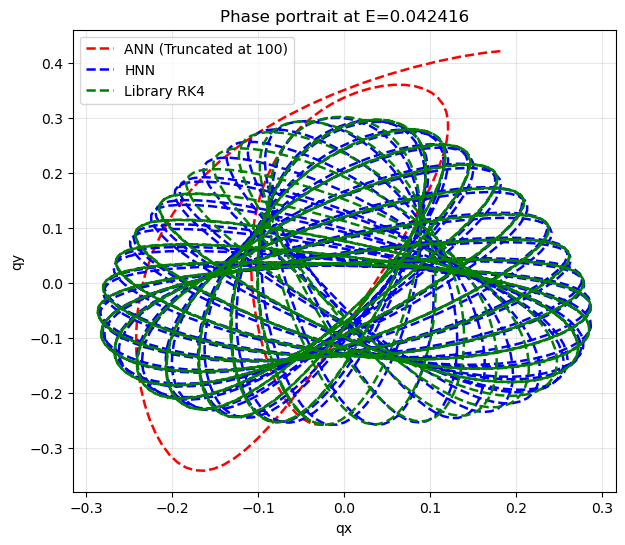

E=0.083833  plotting first 100 steps (ANN's stable trajectory range)


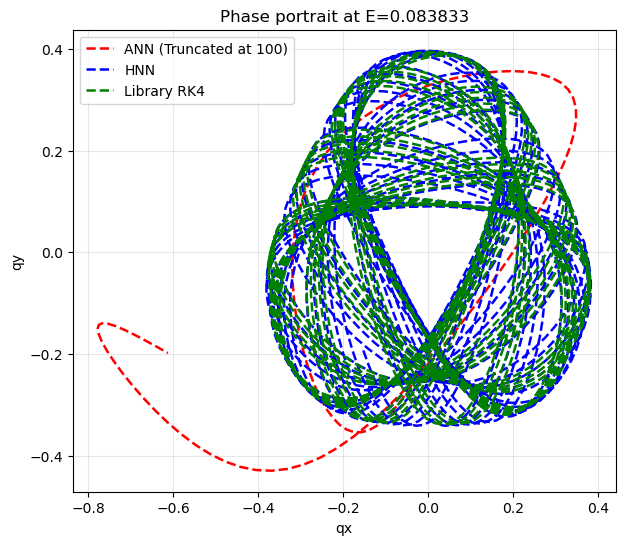

E=0.125249  plotting first 70 steps (ANN's stable trajectory range)


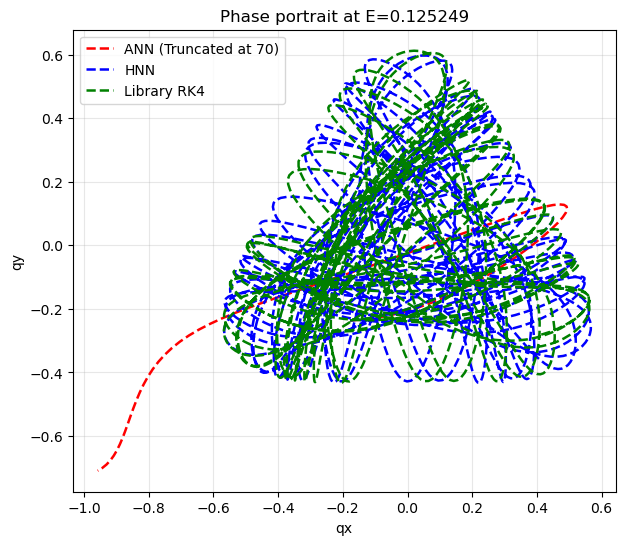

E=0.166666  plotting first 60 steps (ANN's stable trajectory range)


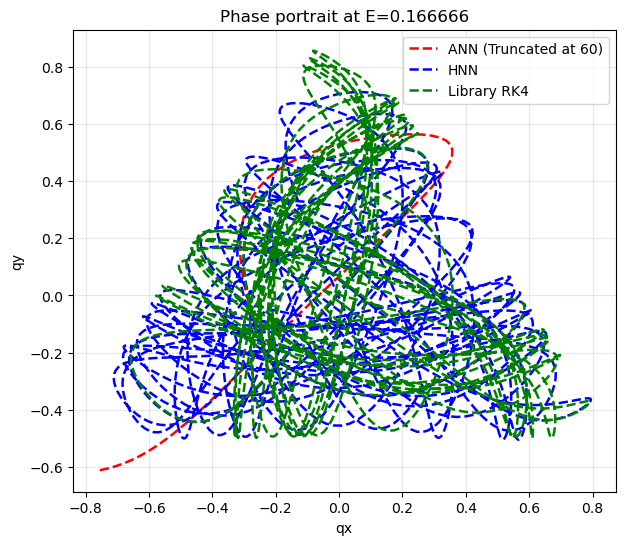

In [138]:
#Same plots here, but I am showing the HNN, and Library trajectories fully to demosntrate that HNN doesnt diverge
#The ANN Trajectories diverge after some time, so I am plotting only the stable parts
#It shows that HNN is much more stable than ANN
cutoffs = {
    energies_test[0]: 100,
    energies_test[1]: 100,
    energies_test[2]: 100,
    energies_test[3]: 70,
    energies_test[4]: 60,
}

for E in energies_test:
    R = results[E]
    if E in cutoffs:
        N = cutoffs[E]

    print(f"E={E:.6f}  plotting first {N} steps (ANN's stable trajectory range)")
    plt.figure(figsize=(7,6))
    plt.plot(R["ann"][:N,0], R["ann"][:N,1], 'r--', label=f"ANN (Truncated at {N})")
    plt.plot(R["hnn"][:,0], R["hnn"][:,1], 'b--', label="HNN")
    plt.plot(R["lib"][:,0], R["lib"][:,1], 'g--', label="Library RK4")

    plt.xlabel("qx")
    plt.ylabel("qy")
    plt.title(f"Phase portrait at E={E:.6f}")
    plt.legend()
    plt.grid(True)
    plt.show()

We observe that the ANN trajectories diverge quicker at higher energies. This is discussed in the report and the slides.


E=0.001000  using ANN energy up to step 100


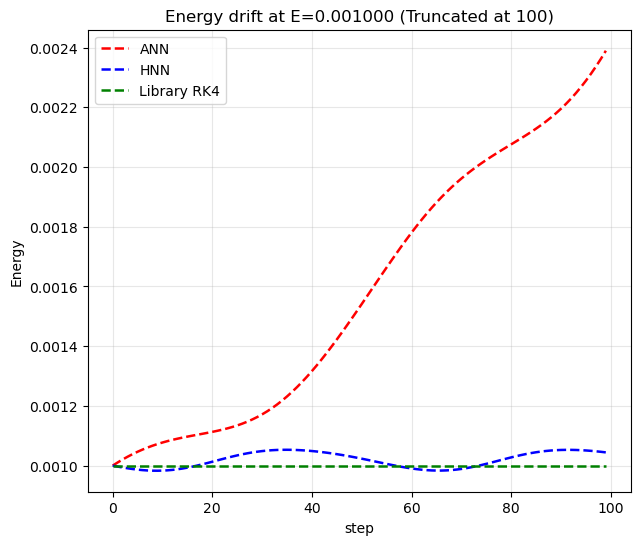

E=0.042416  using ANN energy up to step 100


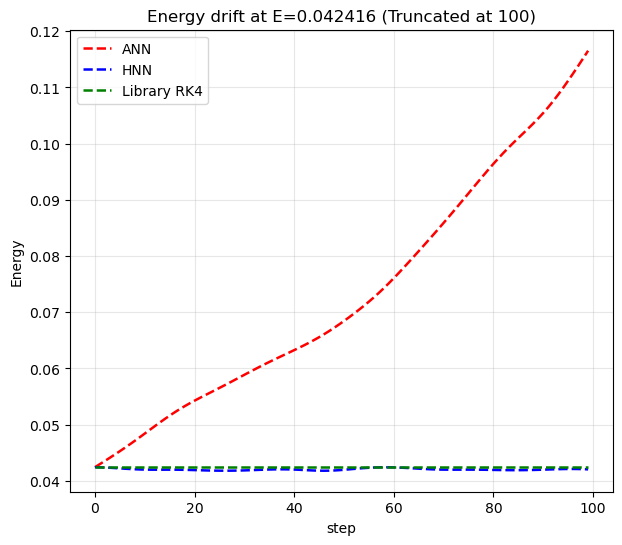

E=0.083833  using ANN energy up to step 100


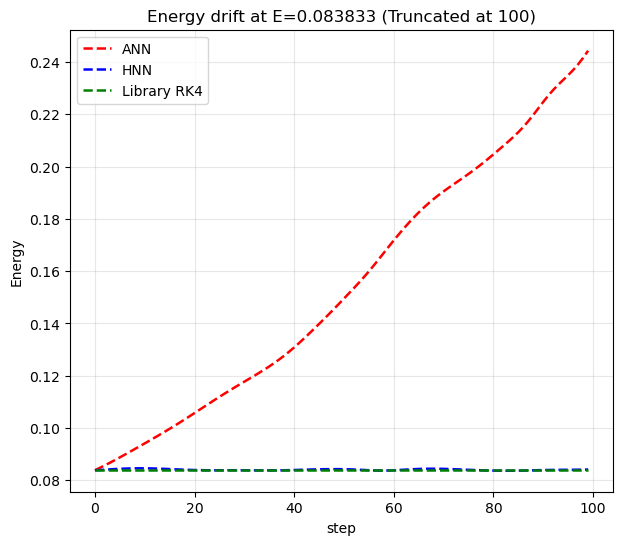

E=0.125249  using ANN energy up to step 70


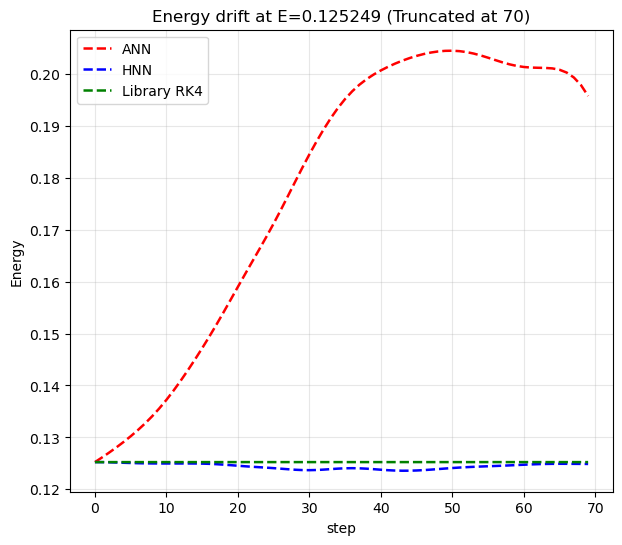

E=0.166666  using ANN energy up to step 60


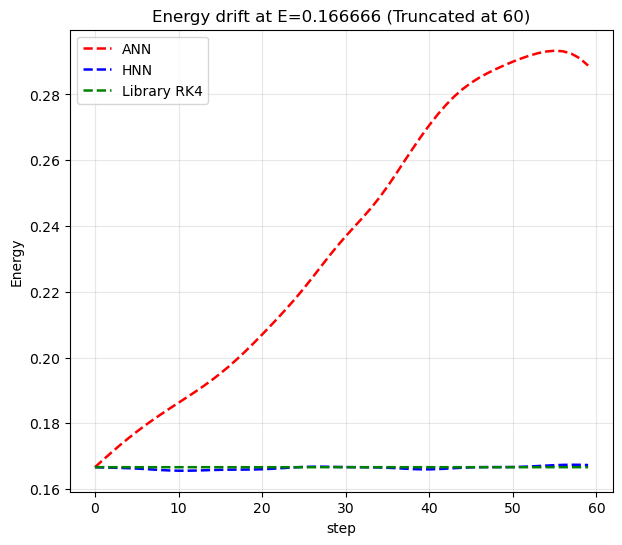

In [141]:
cutoffs_energy = {
    energies_test[0]: 100,
    energies_test[1]: 100,
    energies_test[2]: 100,
    energies_test[3]: 70,
    energies_test[4]: 60,
}

for E in energies_test:
    R = results[E]
    N = cutoffs_energy[E]

    print(f"E={E:.6f}  using ANN energy up to step {N}")
    plt.figure(figsize=(7,6))
    plt.plot([Hamiltonian(*z) for z in R["ann"][:N]],'r--', label=f"ANN")
    plt.plot([Hamiltonian(*z) for z in R["hnn"][:N]],'b--', label="HNN")
    plt.plot([Hamiltonian(*z) for z in R["lib"][:N]],'g--', label="Library RK4")
    plt.title(f"Energy drift at E={E:.6f} (Truncated at {N})")
    plt.xlabel("step")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True)
    plt.show()



Now, just to illustrate the fact that the HNN Trajectories were not diverging, I will plot the full trajectories for HNN and Library RK4 along with the stable part of the ANN Trajectories. 


=== Plotting for E = 0.125249 ===
Using ANN cutoff = 70 steps


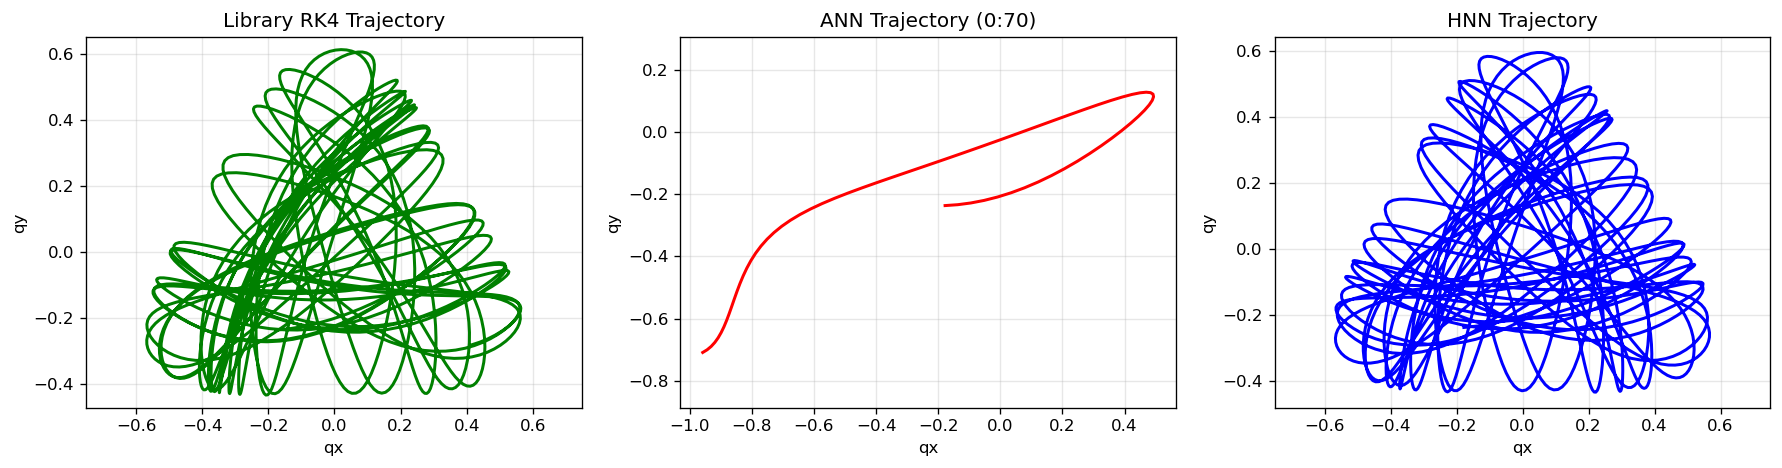


=== Plotting for E = 0.166666 ===
Using ANN cutoff = 60 steps


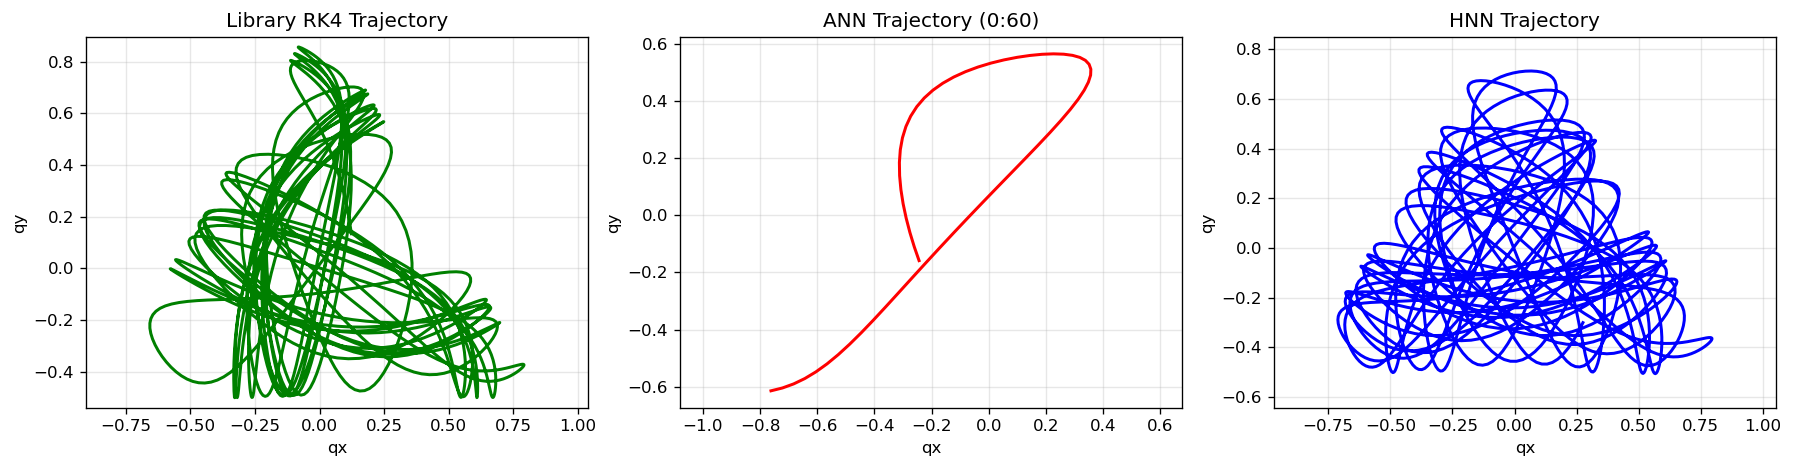

In [145]:
plt.rcParams.update({"font.size": 10, "axes.grid": True, "grid.alpha": 0.3, "lines.linewidth": 1.8})

#The last two trajectories are chaotic, since they are at higher energies
#So I am plotting those separately for each model to see the differences clearly
#The cutoffs are the time steps after I observed ANN trajectories diverging for each energy
#This way I can show that HNN remains stable while ANN diverges
ann_cutoffs = {energies_test[-2]: 70, energies_test[-1]: 60}

for E in energies_test[-2:]:
    R = results[E]
    print(f"\n=== Plotting for E = {E:.6f} ===")
    N = ann_cutoffs[E]
    
    print(f"Using ANN cutoff = {N} steps")

    traj_ann_cut = R["ann"][:N]
    traj_hnn = R["hnn"]
    traj_lib = R["lib"]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=120)
    #LibrarY RK4
    axs[0].plot(traj_lib[:,0], traj_lib[:,1], color="green")
    axs[0].set_title("Library RK4 Trajectory")
    axs[0].set_xlabel("qx")
    axs[0].set_ylabel("qy")
    axs[0].axis("equal")

    #ANN 
    axs[1].plot(traj_ann_cut[:,0], traj_ann_cut[:,1], color="red")
    axs[1].set_title(f"ANN Trajectory (0:{N})")
    axs[1].set_xlabel("qx")
    axs[1].set_ylabel("qy")
    axs[1].axis("equal")

    #HNN
    axs[2].plot(traj_hnn[:,0], traj_hnn[:,1], color="blue")
    axs[2].set_title("HNN Trajectory")
    axs[2].set_xlabel("qx")
    axs[2].set_ylabel("qy")
    axs[2].axis("equal")

    plt.tight_layout()
    plt.show()

